<H1> Premières classification d'images </H1>

Dans ce notebook nous nous intéressons à la classification d'images. Nous présentons comment se comportent des classifiers traditionnels, puis abordons les premiers réseaux de neurones. Enfin nous montrons l'utilisation des modèles de type convolution.   

Le principe pour la classification d'images est le même que précédemment, il y a une étape de pré-traitement (convertir l'image, normaliser, etc.), une étape d'apprentissage avec un jeu d'apprentissage et de test (et bien entendu de la cross validation) et enfin l'établissement du modèle final qui peut être sauvegardé pour être réutilisé par la suite.

## Installation



Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.


**Dans ce notebook nous utilisons des approches comme PCA, T-SNE et UMAP pour faire de la réduction de dimensions et visualiser les données. Les librairies suivantes concernant notamment UMAP doivent forcément être installées - Attention : il faut relancer l'environnement d'exécution une fois que les librairies ont été téléchargées.**

In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

# sous Colab il faut déjà intégrer ces deux librairies

!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

# eventuellement ne pas oublier de relancer le kernel du notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=27448969b85cb26f0bdcae0dec945b43ba53d0eedbe90fed0e7909ac424a65c2
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=67f6aa0efa04e1a53e5c0193a4dfa93b00e7b1e9b187cb52470f112bf008a7dd
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for dat

In [ ]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model

# Umap
import umap.plot
from bokeh.plotting import output_notebook
from bokeh.plotting import *
from bokeh.plotting import figure, show, output_notebook

In [ ]:
def plot_curves_confusion (history,confusion_matrix,class_names):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

  # division de la fenêtre graphique en 1 ligne, 3 colonnes,
  # graphique en position 1 - loss fonction

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  # graphique en position 2 - accuracy
  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')

  # matrice de correlation
  plt.subplot(1,3,3)
  sns.heatmap(conf,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
  # labels, title and ticks
  plt.xlabel('Predicted', fontsize=12)
  #plt.set_label_position('top')
  #plt.set_ticklabels(class_names, fontsize = 8)
  #plt.tick_top()
  plt.title("Correlation matrix")
  plt.ylabel('True', fontsize=12)
  #plt.set_ticklabels(class_names, fontsize = 8)
  plt.show()

Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [ ]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [ ]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024


'/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'

# Le jeu de données MNINST

Dans ce notebook nous allons utiliser le jeu de données Fashion MNIST qui est très classique. Issus de Zalano, il contient 70 000 images en basse résolution (28 x 28 pixels) et en niveaux de gris réparties en 10 catégories correspondant à des parties de vêtements. La base de données est repartie :  60000 exemples d'apprentissage et 10000 exemples de test. Elle est disponible sous keras.

**Remarque :** Fashion MNIST est un peu plus intéressant à analyser que MNIST qui contient des chiffres de 0 à 9 et qui se classe facilement.   

Lecture du jeu de données :

In [44]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Quelques informations sur le jeu de données montrent qu'il y a bien 60000 images pour l'entraînement et que chaque image est une matrice de 28 par 28.

Nombre d'exemples du jeu d'apprentissage :  60000
Format du jeu d'apprentissage :  (60000, 28, 28)
Format des labels pour le jeu d'apprentissage' :  (60000,) 

Nombre d'exemples du jeu de test :  10000
Nombre de features du jeu de test :  28
Format des labels pour le jeu de test :  (10000,) 

Exemple de labels 9 

Distribution des labels dans le jeu d'apprentissage


Text(0.5, 1.0, "Nombre d'éléments par classe")

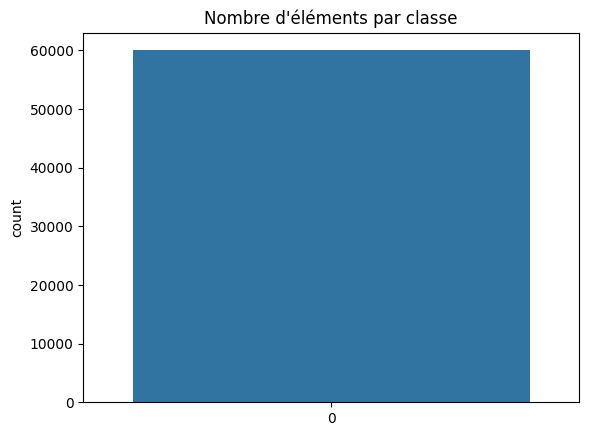

In [45]:
print("Nombre d'exemples du jeu d'apprentissage : ", train_images.shape[0])
print ("Format du jeu d'apprentissage : ", train_images.shape)
print("Format des labels pour le jeu d'apprentissage' : ", train_labels.shape, '\n')
print("Nombre d'exemples du jeu de test : ", test_images.shape[0])
print ("Nombre de features du jeu de test : ", test_images.shape[1])
print("Format des labels pour le jeu de test : ", test_labels.shape, '\n')
print ("Exemple de labels",train_labels[0], '\n')
print ("Distribution des labels dans le jeu d'apprentissage")
sns.countplot(np.array(train_labels))
plt.title("Nombre d'éléments par classe")

Comme les labels sont encodés de 0 à 9, nous créons une classe pour labeliser les images.

In [ ]:
print ("Création d'une classe pour pouvoir labéliser les images lors de l'affichage")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Création d'une classe pour pouvoir labéliser les images lors de l'affichage


Affichage de plusieurs images :

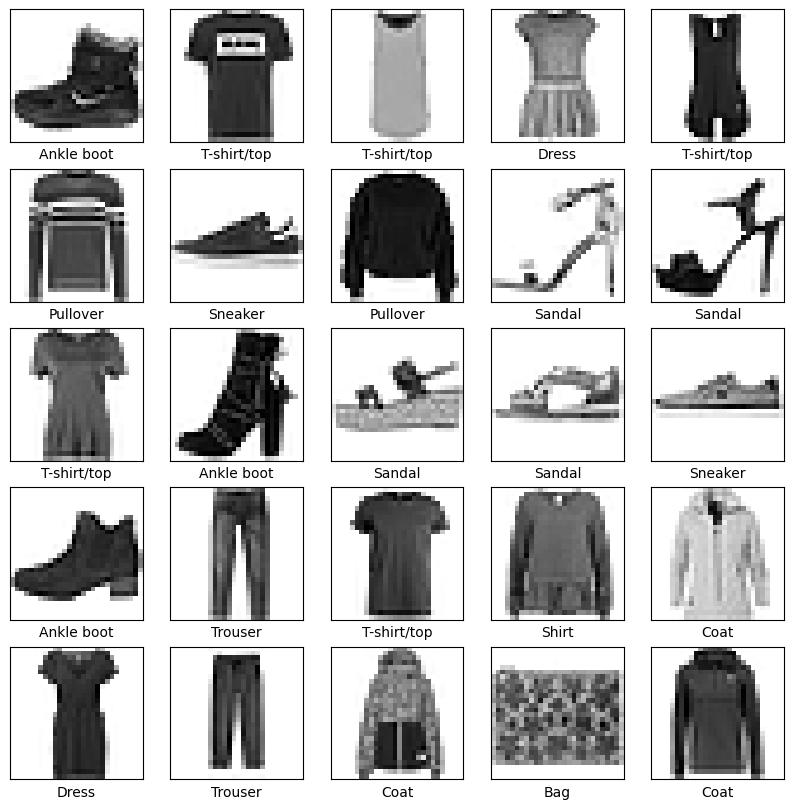

In [ ]:
#Visualisation d'images
plt.figure(figsize=(10,10))
columns = 25
for i in range(columns):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

### Visualisation des données

Il est intéressant lorsque l'on a un jeu de données de regarder aussi comment ces dernières se répartissent dans l'espace. Cela peut permettre de déterminer des outliers, de voir des regroupements qui indiquent que souvent ces données sont plus facilement prédictibles ou au contraire des points de différentes classes très proches qui seront difficilement prédictibles,  etc.  

Etant donné que les données ont un nombre trop grand de dimensions pour être visualisées, une solution consiste à utiliser de la réduction de dimensions. Il existe différentes méthodes comme par exemple :
* PCA (*Principal Component Analysis* - *Analyse en Composantes Principales*) qui consiste à transformer des variables corrélées entre elles (dites « corrélées » en statistique) en nouvelles variables décorrélées les unes des autres, i.e. les composantes principales. Ces nouvelles variables sont nommées « composantes principales ».
* T-SNE (*t-distributed Stochastic Neighbor Embedding*), plus récente et très utilisée en visualisation, utilise  une interprétation probabiliste des proximités, i.e. distribution de probabilité, au lieu des matrices de variance et co-variance de PCA.
* UMAP (*Uniform Manifold Approximation and Projection*), créé en 2018, utilise une technique de réduction de dimension non linéaire.

Nous montrons par la suite différentes visualisations obtenues avec ces méthodes. Le jeu de données étant très volumineux (60 000 pour le jeu d'entraînement), nous utiliserons uniquement 3000 images pour illustrer.  

Préparation des données :   

**Attention :**  une image correspond à une matrice, ce qui veut dire que nous manipulons pour train_images un tenseur de la forme (60000, 28, 28) où 60000 correspond au nombre d'images et 28, 28 à la matrice de pixels de l'image. Pour pouvoir utiliser les méthodes précédentes ou pour pouvoir utiliser un classifier traditionnel, il est nécessaire de transformer la matrice associée à chaque image en un vecteur. Pour cela nous utilisons reshape qui va donc nous donner (60000, 784).

In [ ]:
# reshape pour pouvoir afficher
nb_images=3000
print ("Sélection de ",nb_images," images de train_images à visualiser")
print ("Forme du jeu de données à visualiser",train_images[:nb_images].shape)
train_images_reshaped = train_images[:nb_images].reshape((nb_images, 28 * 28))
print ("Forme du jeu de données après reshape (transformation en vecteur)",train_images_reshaped.shape)

# Definition des données à afficher
X_plot = train_images_reshaped[:nb_images]
y_plot = train_labels[:nb_images]

label_dictionnary = {
        0:'T-shirt/top',
        1:'Trouser',
        2:'Pullover',
        3:'Dress',
        4:'Coat',
        5:'Sandal',
        6:'Shirt',
        7:'Sneaker',
        8:'Bag',
        9:'Ankle Boot',
    }

def true_label(x):
    return label_dictionnary[x]


Target_names=[]
for i in range(0,nb_images):
  Target_names=np.append(Target_names,true_label(y_plot[i]))

Sélection de  3000  images de train_images à visualiser
Forme du jeu de données à visualiser (3000, 28, 28)
Forme du jeu de données après reshape (transformation en vecteur) (3000, 784)


Utilisation de PCA :

In [ ]:
# Utilisation de PCA
pca = PCA(n_components=2)
pca.fit(X_plot)
X_pca = pca.transform(X_plot)

trace0 = go.Scatter(
    x = X_pca[:,0],
    y = X_pca[:,1],
    mode = 'markers',
    text = Target_names,
    showlegend = False,
    marker = dict(
        size = 8,
        color = y_plot,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

Nous pouvons constater qu'avec PCA il n'est pas facile de voir les différentes classes.  

Utilisation de TSNE :

In [ ]:
# Utilisation de TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_plot)

traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    text = Target_names,
    mode = 'markers',
    showlegend = True,
    marker = dict(
        size = 8,
        color = y_plot,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

Nous constatons que T-SNE fait apparaître de manière plus précise des classes. Ces dernières seront sans doute plus simple à prédire.  

Utilisation de UMAP :

<Axes: >

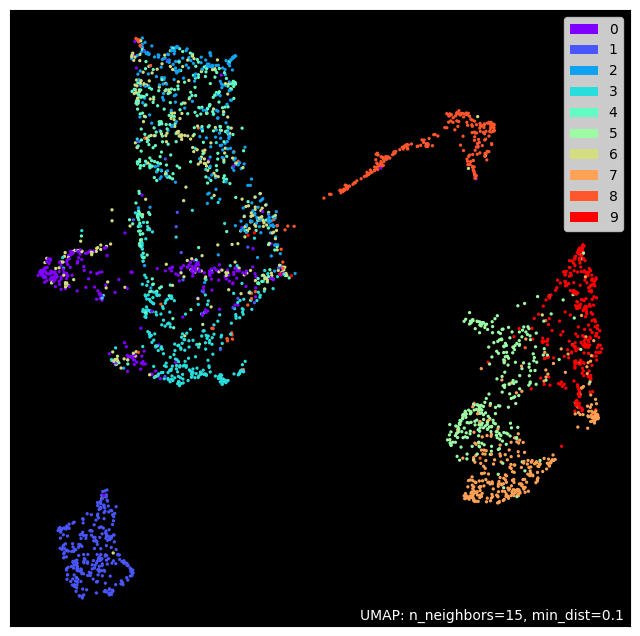

In [ ]:
import umap.plot
mapper = umap.UMAP().fit(X_plot)

# utilisation d'un dataframe pour afficher les moints
hover_data = pd.DataFrame({'index':np.arange(nb_images),
                           'label':y_plot})
hover_data['item'] = hover_data.label.map(label_dictionnary)

# affichage de la visualisation dans le notebook
umap.plot.output_notebook()

# Utilisation de umap en interactif
#p = umap.plot.interactive(mapper, labels=y_plot,
#                          hover_data=hover_data, point_size=6)
#umap.plot.show(p)
umap.plot.points(mapper, labels=y_plot, theme='fire')

Comme pour T-SNE nous voyons des classes qui semblent facile à prédire alors que d'autres sont clairement difficiles car très imbriquées.

### Pré-traitement des données

Inspection d'une image en affichant les valeurs des pixels :

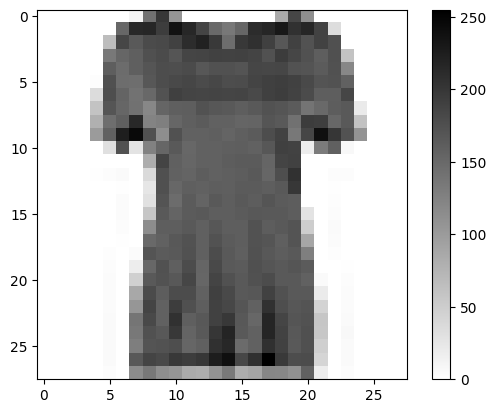

In [ ]:
numimage=10
plt.figure()
plt.imshow(train_images[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
#plt.xlabel(class_names[train_labels[numimage]])
plt.show()

**Transformation des donnees**  
Nous pouvons constater que les valeurs de gris des pixels varient de 0 à 255 (droite de l'image). Il faut donc les "normaliser" entre 0 et 1. Ne pas oublier d'effectuer le même traitement pour le jeu de test.

In [ ]:
# Sauvegarde des données avant transformation
train_images_original=copy.deepcopy(train_images)
test_images_original=copy.deepcopy(test_images)

train_images = train_images / 255.0
test_images = test_images / 255.0

Affichage pour vérifier que la transformation a bien été réalisée.

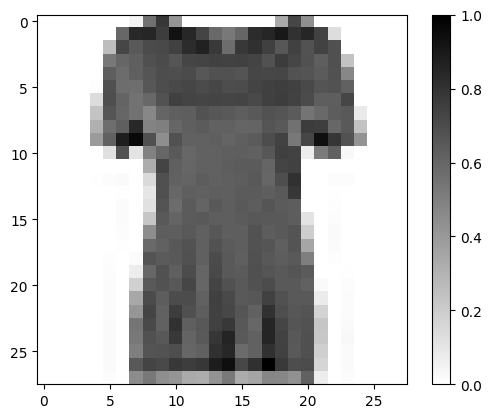

In [ ]:
numimage=10
plt.figure()
plt.imshow(train_images[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
#plt.xlabel(class_names[train_labels[numimage]])
plt.show()

## Un modèle "traditionnel"


Dans cette section, nous utilisons un classifier "traditionnel", i.e. ceux que nous avons l'habitude d'utiliser précédemment. En fait, il s'agit ici de créer un modèle baseline afin de pouvoir avoir une comparaison.   

Pour rappel, comme l'image est une matrice, il est d'abord nécessaire de l'"applatir", i.e. de la transformer en vecteur. Par la suite comme il y a beaucoup de features, nous utiliserons une PCA pour réduire le nombre de dimensions. Enfin nous utilisons un simple modèle Naïve Bayes.   

De manière à ne pas être biaisé par la répartition des données, il est important de faire une cross validation.

In [ ]:
seed=7
nb_splits=10
k_fold = KFold(n_splits=nb_splits, shuffle=True, random_state=seed)

pipe = Pipeline([('pca',PCA(n_components=100)),
                 ('clf',GaussianNB())])

scoring = 'accuracy'
# transformation des données d'entrainement en vecteur
train_images_reshaped = train_images.reshape((train_images.shape[0], 28 * 28))

print ("Evaluation de ",pipe["clf"], " sur ", nb_splits, " splits")
score = cross_val_score(pipe, train_images_reshaped, train_labels, cv=k_fold, scoring=scoring)

print('Les différentes accuracy pour les ",nb_splits, " évaluations sont : \n',
      score,'\n')
print ('Accuracy moyenne : %0.3f'%(score.mean()),
       ' standard deviation %0.3f'%(score.std()))

# prediction sur les données de test
# attention ne pas oublier de faire un pipe.fit pour créer le modèle final
pipe.fit(train_images_reshaped, train_labels)

# transformation des données de test en vecteur au lieu de matrice
test_images_reshaped=test_images.reshape((test_images.shape[0], 28 * 28))
y_predicted = pipe.predict(test_images_reshaped)

print("Accuracy sur le jeu de test", accuracy_score(test_labels, y_predicted))

Evaluation de  GaussianNB()  sur  10  splits
Les différentes accuracy pour les ",nb_splits, " évaluations sont : 
 [0.76666667 0.77733333 0.77366667 0.76366667 0.7795     0.76233333
 0.77533333 0.76083333 0.76183333 0.7725    ] 

Accuracy moyenne : 0.769  standard deviation 0.007
Accuracy sur le jeu de test 0.7578


Il est clair que Naïve Bayes n'est sans doute pas le meilleur classifieur pour ce jeu de données. Nous pourrions utiliser SVC, RandomForest, etc. et tester les différents hyperparamètres (en utilisant par exemple gridsearchCV).

## Un modèle simple de réseau de neurones

La construction du réseau consiste à tout d'abord spécifier les différentes couches. Ce premier modèle est séquentiel. Nous allons tout d'abord 'applatir' la matrice en ajoutant une couche *flatten* qui permet ainsi d'obtenir un vecteur de taille 784 (24x24). Par la suite nous ajoutons une couche contenant 128 neurones avec comme fonction d'activation *relu*. Enfin la dernière couche contient 10 neurones (les différentes parties de vêtements possible) et comme il s'agit de classification multi-classes, la fonction d'activation est *softmax*.

In [ ]:
model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(28, 28)))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

Pour afficher le modèle créé :

In [ ]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


Le modèle a 101770 paramètres !

**Choix de la fonction de perte** :  
Nous sommes dans le cas d'une classification multi-classes, nous pouvons utiliser la cross entropy. Sous Keras, la *sparse_categorical_crossentropy* permet de réaliser la cross entropy sans nécessité que les labels aient, au préalable, été transformés par un one-hot encoding.


In [ ]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=8
batch_size=64
history=model1.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=epochs, batch_size=batch_size)


Epoch 1/8
938/938 [==============================] - 5s 4ms/step - loss: 0.5102 - accuracy: 0.8234 - val_loss: 0.4363 - val_accuracy: 0.8456
Epoch 2/8
938/938 [==============================] - 3s 4ms/step - loss: 0.3847 - accuracy: 0.8648 - val_loss: 0.3937 - val_accuracy: 0.8612
Epoch 3/8
938/938 [==============================] - 3s 4ms/step - loss: 0.3461 - accuracy: 0.8749 - val_loss: 0.3977 - val_accuracy: 0.8539
Epoch 4/8
938/938 [==============================] - 5s 6ms/step - loss: 0.3217 - accuracy: 0.8839 - val_loss: 0.3639 - val_accuracy: 0.8698
Epoch 5/8
938/938 [==============================] - 3s 3ms/step - loss: 0.3032 - accuracy: 0.8890 - val_loss: 0.3634 - val_accuracy: 0.8718
Epoch 6/8
938/938 [==============================] - 3s 4ms/step - loss: 0.2884 - accuracy: 0.8945 - val_loss: 0.3584 - val_accuracy: 0.8730
Epoch 7/8
938/938 [==============================] - 4s 4ms/step - loss: 0.2778 - accuracy: 0.8969 - val_loss: 0.3461 - val_accuracy: 0.8776
Epoch 8/8
938

Il suffit alors d'afficher les courbes associées en *accuracy* et *loss* pour mieux comprendre le comportement.

313/313 [==============================] - 1s 2ms/step

Rappel du modèle testé
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None 

Accuracy sur le jeu de test 0.8824


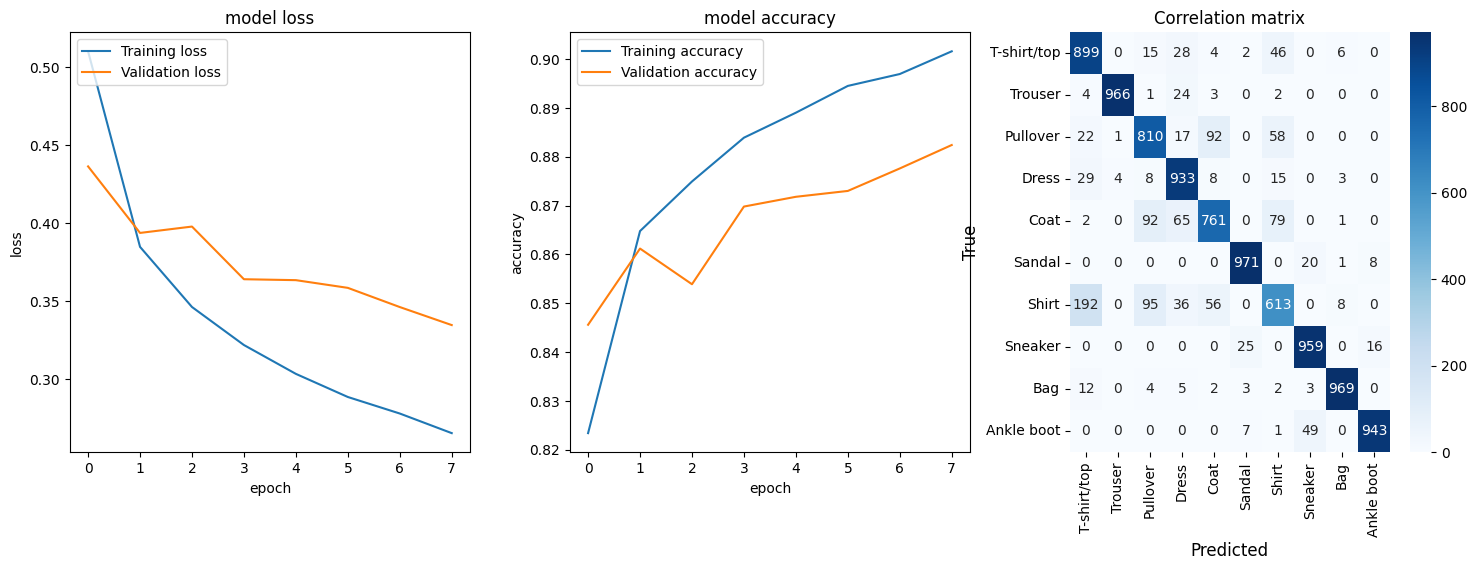

In [ ]:
#utilisation de predict et argmax car c'est un softmax
# la valeur retournée est un vecteur de probabilité, on retient la plus grande valeur pour la classe
predict_y=model1.predict(test_images)
y_pred=np.argmax(predict_y,axis=1)


print ("\nRappel du modèle testé")
print (model1.summary(),'\n')

print("Accuracy sur le jeu de test", accuracy_score(test_labels, y_pred))

conf=confusion_matrix(test_labels,y_pred)
plot_curves_confusion (history,conf,class_names)

Nous voyons que l'accuracy de ce modèle de réseau de neurones simple (Multi Layer Perceptron) est nettement meilleur que celle du Naïve Bayes précédent.   
Il est intéressant de regarder la matrice de confusion et les visualisations précédentes pour vérifier que les classes qui étaient difficiles à prédire ... se retrouve souvent mal classées dans la matrice.   

Il est possible bien entendu d'essayer d'encore améliorer ce modèle.

**Attention :** dans l'expérience précédente nous n'avons pas fait un k-fold donc, même si le batchsize va prendre un échantilon à chaque passage, il va travailler sur les mêmes données. Dans la cellule suivante, nous montrons la modification à apporter pour pouvoir effectuer une cross validation et donc bien tester les performances réelles du modèle. Bien entendu, l'apprentissage est plus long !

In [ ]:
# Concaténation du jeu d'apprentissage et de test
inputs = np.concatenate((train_images, test_images), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

nb_folds=2
epochs=8
batch_size=64

kfold = KFold(n_splits=nb_folds, shuffle=True)

# Cross-validation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Definition de l'architecture du modèle
  model1 = models.Sequential()
  model1.add(layers.Flatten(input_shape=(28, 28)))
  model1.add(layers.Dense(128, activation='relu'))
  model1.add(layers.Dense(10, activation='softmax'))

  # Compilation du modèle
  model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  print('\nEntrainement pour le fold  ', fold_no, ' ')

  # Fit data sur les données
  history = model1.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=epochs)

  # Récupération des métriques (accuracy et loss)
  scores = model1.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score pour fold {fold_no} : {model1.metrics_names[0]} = {scores[0]} - {model1.metrics_names[1]} = {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Augmentation du nombre de folds
  fold_no = fold_no + 1

# Les scores
print('Scores par fold :\n')
for i in range(0, len(acc_per_fold)):
  print(" \tFold ",i+1, "Accuracy : ",acc_per_fold[i],"% - Loss: ",loss_per_fold[i])
print('\nScores moyens pour tous les folds:')
print(f' \tAccuracy : {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f' \tLoss : {np.mean(loss_per_fold)}')



Entrainement pour le fold   1  
Epoch 1/8
547/547 [==============================] - 3s 3ms/step - loss: 0.5780 - accuracy: 0.8017
Epoch 2/8
547/547 [==============================] - 2s 3ms/step - loss: 0.4276 - accuracy: 0.8502
Epoch 3/8
547/547 [==============================] - 2s 3ms/step - loss: 0.3870 - accuracy: 0.8648
Epoch 4/8
547/547 [==============================] - 2s 3ms/step - loss: 0.3595 - accuracy: 0.8741
Epoch 5/8
547/547 [==============================] - 2s 4ms/step - loss: 0.3382 - accuracy: 0.8798
Epoch 6/8
547/547 [==============================] - 4s 8ms/step - loss: 0.3209 - accuracy: 0.8843
Epoch 7/8
547/547 [==============================] - 2s 4ms/step - loss: 0.3029 - accuracy: 0.8904
Epoch 8/8
547/547 [==============================] - 2s 3ms/step - loss: 0.2906 - accuracy: 0.8950
Score pour fold 1 : loss = 0.3506132960319519 - accuracy = 87.2085690498352%

Entrainement pour le fold   2  
Epoch 1/8
547/547 [==============================] - 3s 4ms/step 

# Un modèle plus compliqué : modèle à convolution (CNN)

Dans cette section nous utilisons un modèle de CNN particulièrement bien adapté aux images.

Comme les images sont en niveau de gris, il manque une dimension (couleur RVB). Pour cela nous transformons les données de la manière suivante :

In [ ]:
train_images = train_images_original.reshape(60000, 28, 28, 1)
test_images = test_images_original.reshape(10000, 28, 28, 1)

Contrairement au précédent, nous n'applatissons pas les données mais considérons que les données d'entrées sont bien de la forme 28x28 pixels (*input_shape*). Nous passons par l'intermédiaire d'une couche de convolution 2D qui est suivie par une maxPooling. Enfin nous applatissons (*Flatten*) la sortie du maxPooling et ajoutons une couche dense. La dernière couche, comme précédemment contient 10 neurones et une fonction de sortie softmax pour la classification multi-classes.

In [ ]:
cnnmodel = tf.keras.Sequential()
# 1 couche de convolution, avec nombre de filtres progressif 32
cnnmodel.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 1), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2)))
# remise à plat
cnnmodel.add(Flatten())
# Couche dense classique ANN
cnnmodel.add(Dense(100, activation='relu'))
# Couche de sortie (classes de 0 à 9)
cnnmodel.add(Dense(10, activation='softmax'))


Architecture du modèle :

In [ ]:
print (cnnmodel.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               540900    
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

Cette fois ci il y a 542230 paramètres à appendre !

In [ ]:
cnnmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

epochs=4
batch_size=64
history=cnnmodel.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=epochs, batch_size=batch_size)


Epoch 1/4
938/938 [==============================] - 37s 38ms/step - loss: 1.2914 - accuracy: 0.8306 - val_loss: 0.3840 - val_accuracy: 0.8717
Epoch 2/4
938/938 [==============================] - 35s 37ms/step - loss: 0.3104 - accuracy: 0.8904 - val_loss: 0.3292 - val_accuracy: 0.8843
Epoch 3/4
938/938 [==============================] - 34s 37ms/step - loss: 0.2533 - accuracy: 0.9071 - val_loss: 0.3435 - val_accuracy: 0.8822
Epoch 4/4
938/938 [==============================] - 36s 38ms/step - loss: 0.2276 - accuracy: 0.9143 - val_loss: 0.3319 - val_accuracy: 0.8886


313/313 [==============================] - 2s 6ms/step

Rappel du modèle testé
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               540900    
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 5

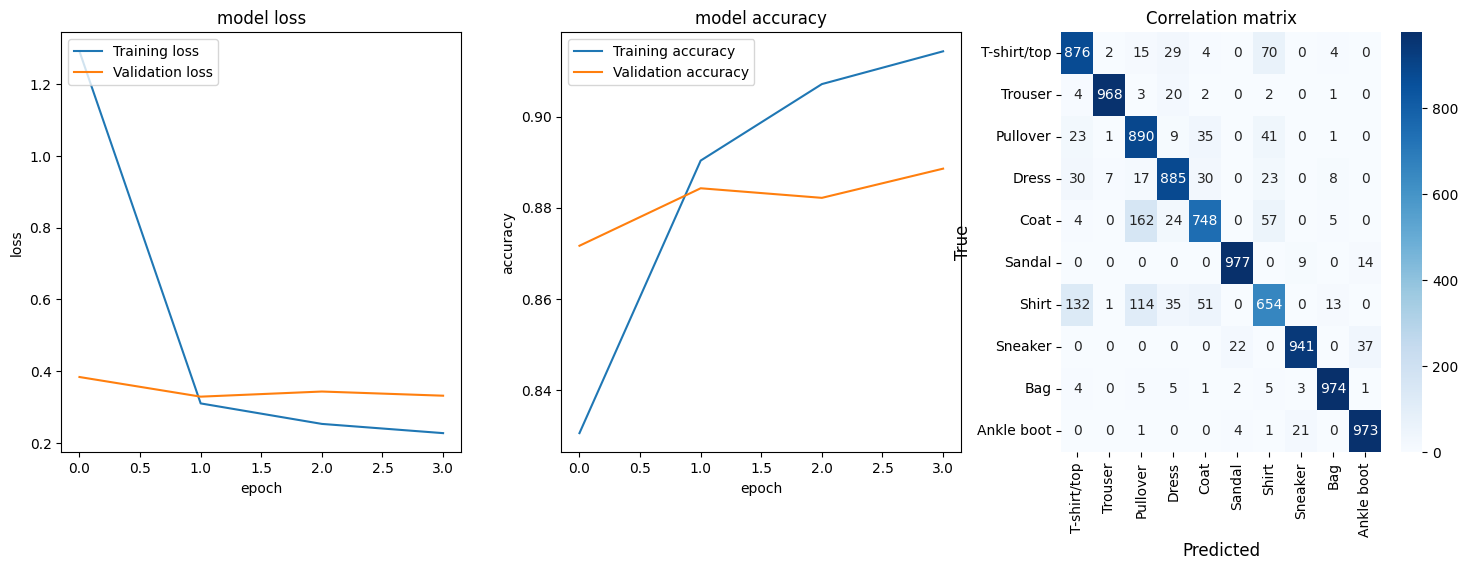

In [ ]:
#utilisation de predict_classes car c'est un softmax
#y_pred=model1.predict_classes(test_images)
predict_y=cnnmodel.predict(test_images)
y_pred=np.argmax(predict_y,axis=1)

print ("\nRappel du modèle testé")
print (cnnmodel.summary(),'\n')

print("Accuracy sur le jeu de test", accuracy_score(test_labels, y_pred))

conf=confusion_matrix(test_labels,y_pred)
plot_curves_confusion (history,conf,class_names)

Le modèle par CNN obtient d'encore meilleurs résultats.

Nous analysons les performances à l'aide d'une cross validation.


In [ ]:
# Concaténation du jeu d'apprentissage et de test
inputs = np.concatenate((train_images, test_images), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

nb_folds=2
epochs=4
batch_size=64

kfold = KFold(n_splits=nb_folds, shuffle=True)

# Cross-validation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Definition de l'architecture du modèle
  cnnmodel = tf.keras.Sequential()
  cnnmodel.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 1), activation='relu'))
  cnnmodel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(100, activation='relu'))
  cnnmodel.add(Dense(10, activation='softmax'))


  # Compilation du modèle
  cnnmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  print('\nEntrainement pour le fold  ', fold_no, ' ')

  # Fit data sur les données
  history = cnnmodel.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=epochs)

  # Récupération des métriques (accuracy et loss)
  scores = cnnmodel.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score pour fold {fold_no} : {model1.metrics_names[0]} = {scores[0]} - {model1.metrics_names[1]} = {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Augmentation du nombre de folds
  fold_no = fold_no + 1

# Les scores
print('Scores par fold :\n')
for i in range(0, len(acc_per_fold)):
  print(" \tFold ",i+1, "Accuracy : ",acc_per_fold[i],"% - Loss: ",loss_per_fold[i])
print('\nScores moyens pour tous les folds:')
print(f' \tAccuracy : {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f' \tLoss : {np.mean(loss_per_fold)}')



Entrainement pour le fold   1  
Epoch 1/4
547/547 [==============================] - 19s 34ms/step - loss: 2.4006 - accuracy: 0.7970
Epoch 2/4
547/547 [==============================] - 21s 39ms/step - loss: 0.3539 - accuracy: 0.8793
Epoch 3/4
547/547 [==============================] - 19s 35ms/step - loss: 0.2779 - accuracy: 0.8999
Epoch 4/4
547/547 [==============================] - 19s 34ms/step - loss: 0.2343 - accuracy: 0.9151
Score pour fold 1 : loss = 0.3324560225009918 - accuracy = 89.00285959243774%

Entrainement pour le fold   2  
Epoch 1/4
547/547 [==============================] - 19s 34ms/step - loss: 1.9569 - accuracy: 0.7988
Epoch 2/4
547/547 [==============================] - 20s 36ms/step - loss: 0.3560 - accuracy: 0.8785
Epoch 3/4
547/547 [==============================] - 20s 36ms/step - loss: 0.2844 - accuracy: 0.8987
Epoch 4/4
547/547 [==============================] - 18s 34ms/step - loss: 0.2381 - accuracy: 0.9133
Score pour fold 2 : loss = 0.36001256108283997 -

Nous voyons qu'en faisant de la cross validation notre score est meilleur que le modèle précédent. Il peut bien entendu être encore amélioré.  Sur Fashion Mnist vous pouvez via des CNN obtenir assez facilement plus de 90% d'accuracy avec cross validation.


### Sauvegarde et utilisation du modèle

Apprendre un modèle peut, comme nous l'avons vu, être très long ! Aussi une fois le modèle appris, il est important de le sauvegarder.  

**Rappel :** les expérimentations menées sont là pour voir si l'architecture définie nous donne un bon modèle. Par contre à chaque étape nous avons un jeu d'apprentissage et nous évaluons avec le jeu de test. Une fois ces expérimentations réalisées (et qui montrent que le modèle est performant), **il faut relancer le modèle avec tout le jeu de données avant de le sauvegarder**.  

De manière à ne pas générer un modèle trop gros sur le disque, nous ne considérons ici que les images d'entrainement (ici il aurait fallu concaténer *train_images* avec *test_images* et *train_labels* avec *test_labels*).   

L'apprentissage du modèle se fait tout simplement via fit :

In [ ]:
cnnmodel.fit(train_images, train_labels, epochs=4, batch_size=32, verbose=0)

La sauvegarde se fait alors par la commande *save*

In [ ]:
cnnmodel.save('final_modelFMnist.h5')

Pour charger un modèle appris :

In [ ]:
model_loaded = load_model('final_modelFMnist.h5')

Il est maintenant possible de faire des prédictions. Comme le modèle sauvegardé n'a pas utilisé les images du jeu de test, nous pouvons les utiliser.

In [ ]:
# prédiction avec le modèle chargé
nb_images=15
predict_y=model_loaded.predict(test_images[0:nb_images])
y_pred=np.argmax(predict_y,axis=1)
y_pred.astype('int')
for i in range(0,len(y_pred)):
  print ("Classe réelle  ", class_names[test_labels[i]], " - classe prédite", class_names[int(y_pred[i])] )


1/1 [==============================] - 0s 74ms/step
Classe réelle   Ankle boot  - classe prédite Ankle boot
Classe réelle   Pullover  - classe prédite Pullover
Classe réelle   Trouser  - classe prédite Trouser
Classe réelle   Trouser  - classe prédite Trouser
Classe réelle   Shirt  - classe prédite Shirt
Classe réelle   Trouser  - classe prédite Trouser
Classe réelle   Coat  - classe prédite Coat
Classe réelle   Shirt  - classe prédite Shirt
Classe réelle   Sandal  - classe prédite Sandal
Classe réelle   Sneaker  - classe prédite Sneaker
Classe réelle   Coat  - classe prédite Coat
Classe réelle   Sandal  - classe prédite Sandal
Classe réelle   Sneaker  - classe prédite Sneaker
Classe réelle   Dress  - classe prédite Dress
Classe réelle   Coat  - classe prédite Coat


Il reste bien entendu de très nombreuses choses à voir comme prendre en compte la génération d'images pour enrichir les données, le transfer learning pour utiliser des modèles déjà appris, les sauvegardes en cours d'apprentissage si ce dernier est très long, savoir ce qui est reconnu dans l'image pour la classification (e.g. https://arxiv.org/abs/1610.02391), etc..   
